# September 17, 2022: Implement/replicate results in Brenton et al. 2014
This is to verify if the trial level responses in MAX paradigm are reliable, in the sense that observations of the previous studies are seen in the MAX paradigm's dataset.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import (norm, zscore, permutation_test)
from itertools import combinations

from scipy.linalg import pinv, lstsq

# ISC
from brainiak.isc import (
    isc, isfc, bootstrap_isc, compute_summary_statistic, squareform_isfc, compute_correlation,
    _check_timeseries_input, _check_targets_input, _threshold_nans
)
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import squareform
from brainiak.fcma.util import compute_correlation

# network analyses
import networkx as nx

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/sep22"

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils as dataset_utils
import helpers.isc_utils as isc_utils
import helpers.fc_utils as fc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

set_name = 'mashid'

args.SEED = 74
np.random.seed(args.SEED)

# ROIs
roi_set_file = f"{proj_dir}/data/rois/{set_name}/roi_set_{set_name}.csv"
args.roi_set_df = pd.read_csv(roi_set_file)
args.roi_set_df = args.roi_set_df.sort_values(by=['network'])
# display(args.roi_set_df)

args.roi_names = args.roi_set_df['roi_name'].values
args.nw_names = args.roi_set_df['network'].values
args.roi_idxs = args.roi_set_df.index.values
args.num_rois = len(args.roi_idxs)

# trial level responses
with open(f"{proj_dir}/data/max/desc-exploratory_data_trial_level_responses_rois-{set_name}.pkl", 'rb') as f:
    X = pickle.load(f)

# change roi ordering
for label in args.LABELS:
    for idx_subj in range(len(X[label])):
        X[label][idx_subj] = X[label][idx_subj][:, :, args.roi_idxs]

args.num_TRs = X[1][0].shape[1]

# replace nans with 0.0
# because loading factors won't be affected in any way.
for label in args.LABELS:
    for idx_subj in range(len(X[label])):
        X[label][idx_subj] = np.nan_to_num(X[label][idx_subj])

In [3]:
'''
plotting tick labels
'''
ticks = []
for nw in np.unique(args.nw_names):
    ticks.append(np.where(args.nw_names == nw)[0].shape[0])
args.ticks = np.array(ticks)
print(args.ticks)

minor_ticks = np.cumsum(args.ticks)
args.major_ticks = minor_ticks - args.ticks // 2
args.minor_ticks = minor_ticks[:-1]
print(args.minor_ticks)
print(args.major_ticks)

args.major_tick_labels = np.unique(args.nw_names)
print(args.major_tick_labels)

[12 13  8 12]
[12 25 33]
[ 6 19 29 39]
['Executive' 'Salience' 'Subcortical' 'Task negative']


In [4]:
def get_block_time_series(args, X):
    args.PERIODS = ['early', 'late']
    # time periods
    args.TR = 1.25 #seconds
    EARLY = np.arange(2.5, 8.75+args.TR, args.TR) // args.TR
    LATE = np.arange(10.0, 16.25+args.TR, args.TR) // args.TR
    EARLY = EARLY.astype(int)
    LATE = LATE.astype(int)
    args.PERIOD_TRS = [EARLY, LATE]

    # check how nan values are distributed within each trial for each subj
    # for label, name in zip(args.LABELS, args.NAMES):
    #     for idx_period, (period, TRs) in enumerate(zip(args.PERIODS, args.PERIOD_TRS)):
    #         print(f"{name}_{period}")
    #         for x in X[label]:
    #             print(
    #                 np.sum(np.isnan(x[:, TRs, 0]), axis=1)
    #             )

    # design matrix
    A = np.zeros((args.num_TRs, len(args.PERIOD_TRS)))
    for idx_period, (period, TRs) in enumerate(zip(args.PERIODS, args.PERIOD_TRS)):
        # print(idx_period, period, TRs)
        A[TRs, idx_period] = 1.0

    # display(A)

    # loading factors
    Betas = {}
    for label in args.LABELS:
        Betas[label] = []
        for x in X[label]:
            Betas[label].append(
                pinv(A) @ x
            )

    # block time series (of loading factors)
    ts = {}
    for label, name in zip(args.LABELS, args.NAMES):
        for idx_period, period in enumerate(args.PERIODS):
            block = f"{name}_{period}"
            ts[block] = []
            for betas in Betas[label]:
                # ts has shape num_trials x num_rois
                ts[block].append(zscore(betas[:, idx_period, :], axis=0, nan_policy='omit'))

    return Betas, ts

In [5]:
Betas, ts = get_block_time_series(args, X)

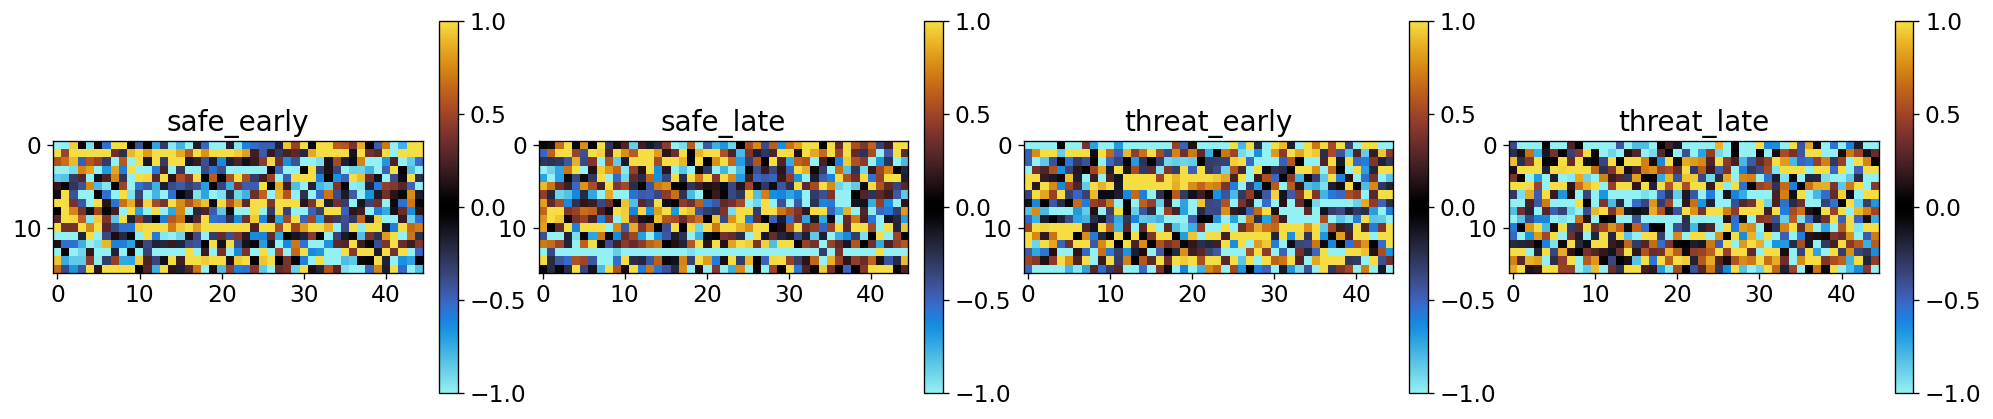

In [6]:
nrows, ncols = 1, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*ncols), dpi=120)
for idx_block, block in enumerate(ts.keys()):
    ax = axs[idx_block]
    im = ax.imshow(
        ts[block][0],
        cmap=cmr.iceburn,
        vmin=-1, vmax=1
    )
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(block)

In [7]:
args.n_bootstraps = 1000
corrs, bootstraps, rois = fc_utils.get_fcs(args, ts)

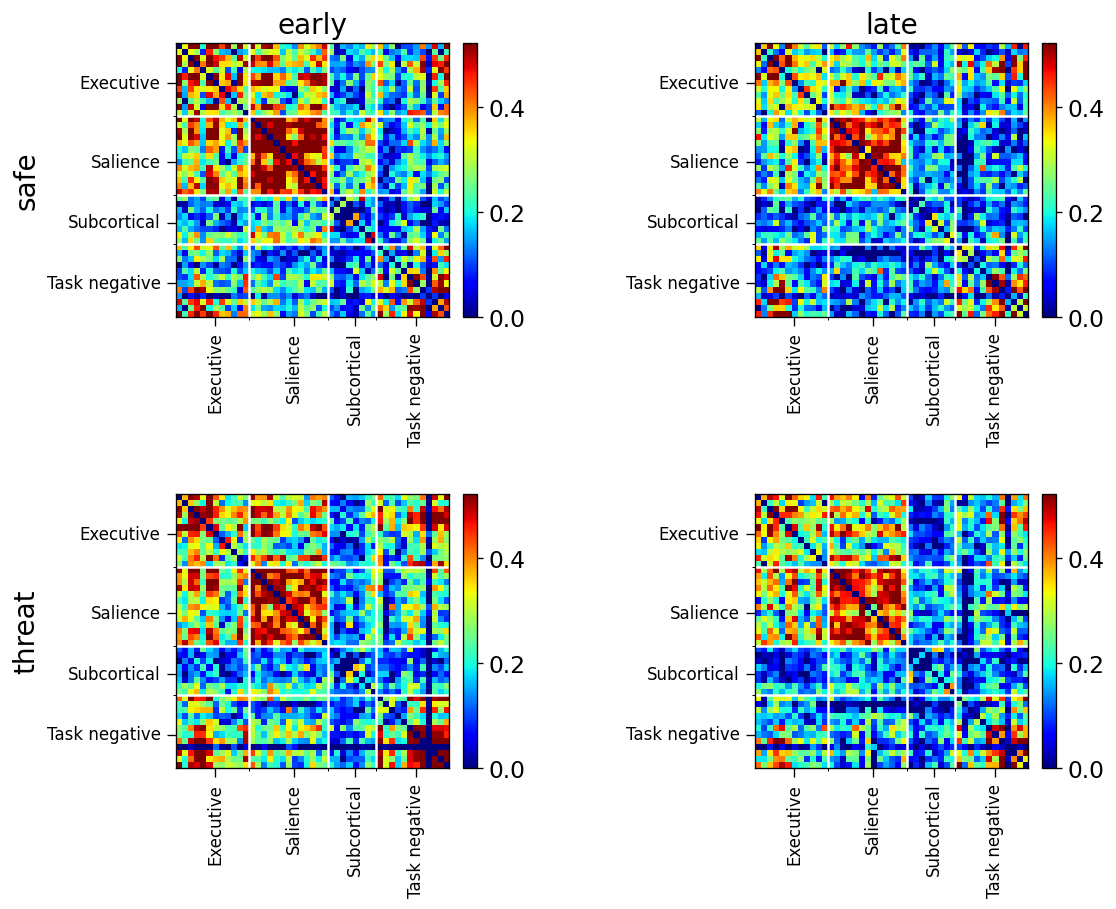

In [8]:
(
    observed_fcs, observed_p_vals, 
    significant_rois, conf_intervals
) = fc_utils.get_squareform_matrices(
    args, 
    bootstraps, 
    rois,
    threshold_mats=True
)

fc_utils.plot_max_fcs(args, observed_fcs, significant_rois, cmap=mpl.colormaps['jet'])

In [9]:
args.n_resamples = 1000
comp_results = fc_utils.get_fc_comparison_stats(args, corrs, paradigm='max')
diff_fcs, diff_pvals = fc_utils.get_diff_fcs(args, comp_results, threshold_mats=True)

6it [00:11,  1.90s/it]


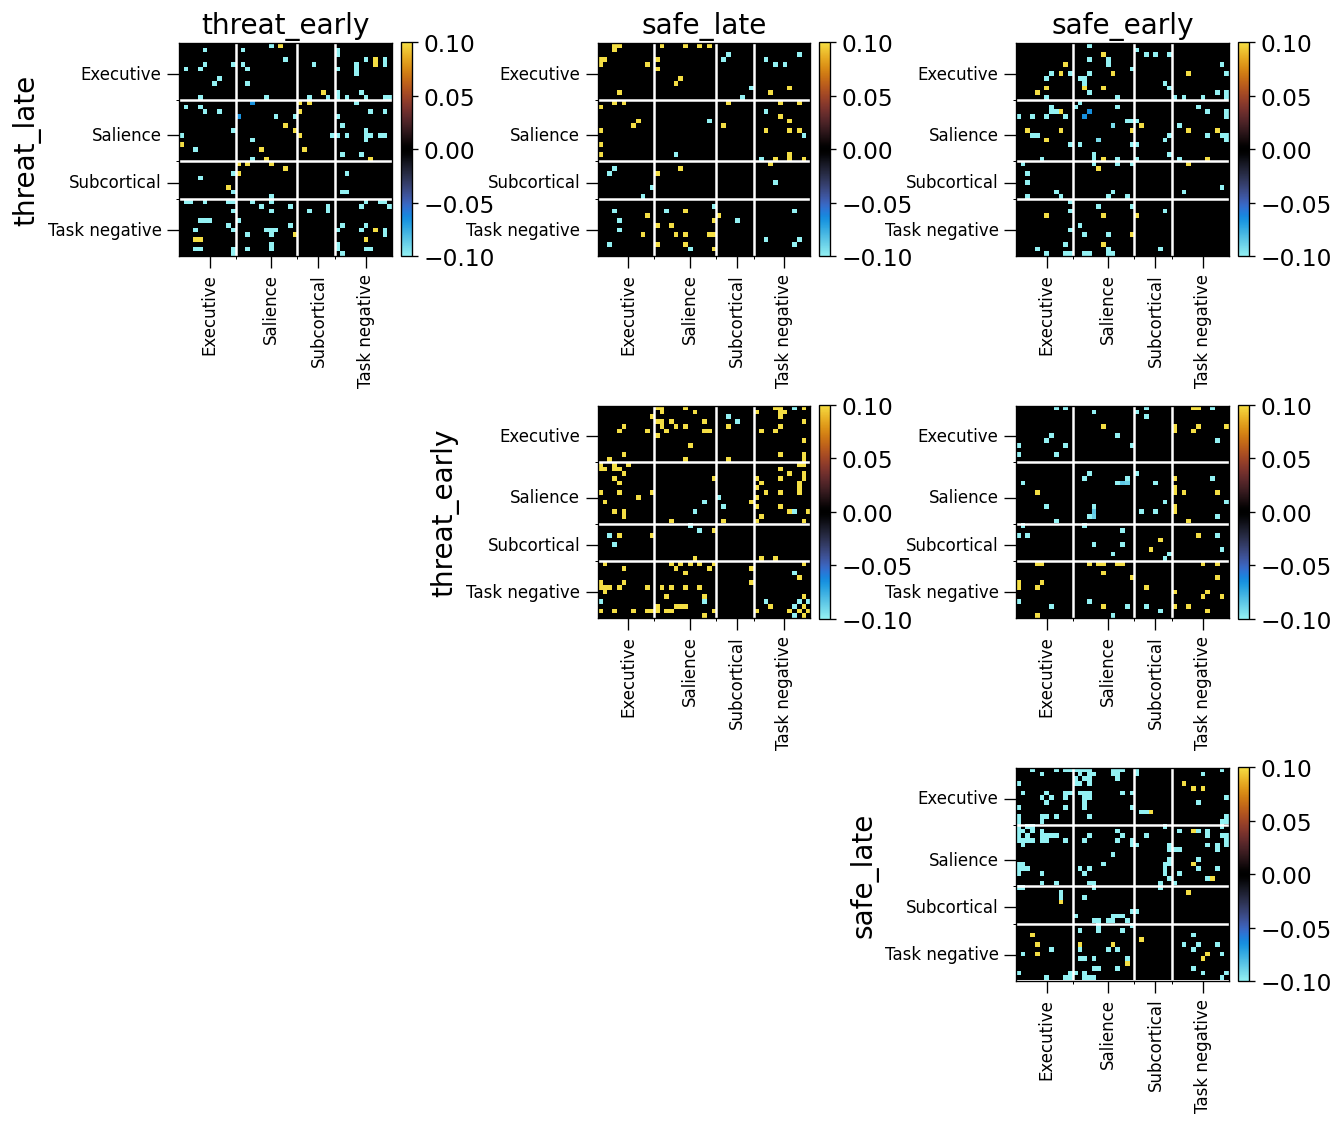

In [10]:
fc_utils.plot_max_fc_comparisons(args, corrs, diff_fcs)